In [159]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import  BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow import keras
%matplotlib inline

In [160]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [161]:
tf.config.list_physical_devices('GPU')

[]

## **1. Remove dodgy images**

In [162]:
data_dir = 'data' 
for image_class in os.listdir(data_dir):
    print(image_class)

happy
sad


In [163]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"Issu with image {image_path}")

## **2. Load Data**

In [164]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [165]:
data_iterator = data.as_numpy_iterator()

In [166]:
batch = data_iterator.next()
len(batch)

2

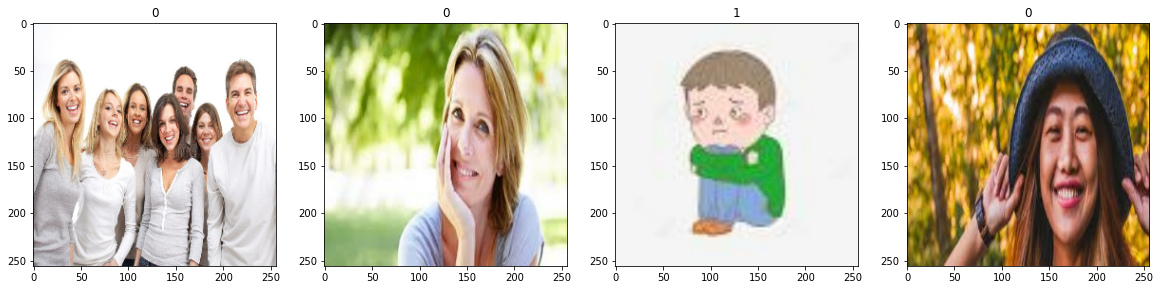

In [167]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## **3. Scale data**

> Scale data when read data using ImageDataGenerator
```
datagen = ImageDataGenerator(samplewise_center=True,
                            rescale=1.0/255,)
train_data = datagen.flow_from_directory(data_dir)
```

In [168]:
data = data.map(lambda x,y: (x/255, y))

In [169]:
data.as_numpy_iterator().next()

(array([[[[0.44978094, 0.4654672 , 0.4767203 ],
          [0.44750306, 0.47103247, 0.47103247],
          [0.45618102, 0.47971043, 0.47971043],
          ...,
          [0.08235294, 0.11764706, 0.14509805],
          [0.07450981, 0.10980392, 0.13725491],
          [0.07596508, 0.11910233, 0.12694547]],
 
         [[0.44560355, 0.45490196, 0.49759498],
          [0.4583793 , 0.4819087 , 0.4819087 ],
          [0.47544423, 0.49897364, 0.49897364],
          ...,
          [0.08235294, 0.11764706, 0.14509805],
          [0.08235294, 0.11764706, 0.14509805],
          [0.07159927, 0.11473652, 0.12257966]],
 
         [[0.45490196, 0.4695772 , 0.49557292],
          [0.4583793 , 0.47798714, 0.5015165 ],
          [0.4627451 , 0.48235294, 0.5058824 ],
          ...,
          [0.08235294, 0.11764706, 0.14509805],
          [0.07406557, 0.10935968, 0.13681066],
          [0.06666667, 0.10980392, 0.13333334]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

## **4. Split data**

> Using ImageDataGenerator() for read data for train and validation
```
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
model.fit(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)
```

In [170]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [171]:
train_size

7

```
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
full_dataset = full_dataset.shuffle()
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
```
> Example using a 70/15/15 train/val/test split but if you don't need a test or a val set, just ignore the last 2 lines.

In [172]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## **6. Build Deep Leaerning Model**

In [173]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [174]:
model = Sequential([
    Conv2D(64, (3,3), 1, activation='relu',input_shape = (256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [175]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 64)      

+ TensorBoard là một công cụ trực quan hóa được cung cấp cùng với TensorFlow. Lệnh gọi lại này ghi lại các sự kiện cho TensorBoard, bao gồm:
   + Biểu đồ tóm tắt chỉ số
   + Hình ảnh hóa biểu đồ đào tạo
   + Biểu đồ cân nặng
   + Hồ sơ được lấy mẫu

In [177]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [178]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 36s 4s/step - loss: 0.7552 - accuracy: 0.6116 - val_loss: 0.6755 - val_accuracy: 0.5781
Epoch 2/20
7/7 [==============================] - 36s 5s/step - loss: 0.4828 - accuracy: 0.7812 - val_loss: 0.7742 - val_accuracy: 0.4688
Epoch 3/20


: 

: 

## **7. Plot performance**

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()